In [1]:
!pip install wfdb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.2 MB/s eta 0:00:00


In [2]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

# preprocessing

In [3]:
def bandpass_filter(signal, fs=250, lowcut=0.5,  highcut=15.0,  order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
def smooth_signal(data, window_size=5):
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)


In [4]:
from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)

# prediction functions

In [5]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != 250:
        signal = resample_signal(signal, original_fs=fs, target_fs=250)
        fs = fs
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    predictions = []

    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions

In [6]:


def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries



In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, signal_name, model_name, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # Convert indices to time (seconds)

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}
    added_labels = set()

    # Convert zoom limits to sample indices
    zoom_start_idx = int(zoom[0] * fs)
    zoom_end_idx = int(zoom[1] * fs) if zoom[1] is not None else len(signal)

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            # Only plot if within zoom range
            if start >= zoom_start_idx and end <= zoom_end_idx:
                label = f'Predicted {wave_type}' if wave_type not in added_labels else None
                plt.fill_between(
                    time[start:end],
                    -1, 1,
                    color=wave_colors.get(wave_type, 'gray'),
                    alpha=0.3,
                    label=label
                )
                added_labels.add(wave_type)

    plt.legend(loc='upper right')
    plt.title(f"signal: {signal_name}, model: {model_name}", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Apply zoom
    plt.xlim(zoom[0], zoom[1] if zoom[1] is not None else time[-1])

    plt.show()

# post process

In [8]:
import numpy as np

def remove_uncomplete_first_last_wave(predicted):
    start = predicted[0]
    end = predicted[-1]
    if start != 0:
      i=0
      while i < len(predicted) and predicted[i]==start:
        i+=1
      predicted[:i]=0
    if end != 0:
      i=len(predicted)-1
      while i > -1 and predicted[i]==end:
        i-=1
      predicted[i+1:]=0

    return predicted

In [9]:
import numpy as np

def merge_close_waves(predicted, max_gap=10):
  predicted = predicted.copy()
  for target_class in [1,2,3]:
    indices = np.where(predicted == target_class)[0]

    if len(indices) < 2:
        return predicted  

    for i in range(len(indices) - 1):
        current = indices[i]
        next_ = indices[i + 1]
        if 0 < next_ - current - 1 < max_gap:
            predicted[current:next_ + 1] = target_class



  return predicted

In [10]:
def remove_irrelevant_waves(predicted,start_search=2,end_search=5):
    start=0
    # Find the first P that has a QRS after it
    if 1 in predicted[:start_search*250] :
      for i in range(len(predicted)-1):
          start = i

          if predicted[i] == 1:
              start = i
              
              while i < len(predicted)-1 and predicted[i] == 1:
                i += 1
              # if it's not 0 or 2 break
              if predicted[i] == 3:
                continue
              # skip background if it exist
              if predicted[i] == 0:
                while i < len(predicted)-1 and predicted[i] == 0:
                  i += 1
              # if it's not qrs continue to next p
              if predicted[i] != 2:
                continue
              else:
                break
      predicted[:start] = 0


    # remove after last T
    if 3 in predicted[-end_search*250:]:
      
      end = predicted[-1]
      for i in range((len(predicted) - 1), -1, -1):
          end = i

          if predicted[i] == 3:
              end = i
              while i > 0 and predicted[i] == 3:
                i -= 1
              # if it's not 0 or 2 break
              if predicted[i] == 1:
                continue
              # skip background if it exist
              if predicted[i] == 0:
                while i > 0 and predicted[i] == 0:
                  i -= 1
              # if it's not qrs continue to next t
              if predicted[i] != 2:
                continue
              else:
                break
      predicted[end+1:] = 0

    return (predicted)



In [11]:
def check_repeated_waves(predicted):
    cleaned = predicted.copy()
    for target_class in [1,2,3]:
      segments = []
      in_segment = False
      start = 0

      # Step 1: Collect all segments of the target class
      for i, val in enumerate(predicted):
          if val == target_class and not in_segment:
              in_segment = True
              start = i
          elif val != target_class and in_segment:
              in_segment = False
              segments.append((start, i - 1))
      if in_segment:
          segments.append((start, len(predicted) - 1))

      # Step 2: Check for pairs of segments with only background (0) in between
      i = 0
      while i < len(segments) - 1:
          s1, e1 = segments[i]
          s2, e2 = segments[i + 1]
          between = cleaned[e1 + 1:s2]

          if np.all(between == 0):  # Only background between them
              len1 = e1 - s1 + 1
              len2 = e2 - s2 + 1

              # Remove the shorter one
              if len1 < len2:
                  cleaned[s1:e1 + 1] = 0
              else:
                  cleaned[s2:e2 + 1] = 0

              # Remove the deleted segment from the list
              segments.pop(i if len1 < len2 else i + 1)
          else:
              i += 1


    return cleaned


In [12]:
from scipy.signal import find_peaks
from tqdm import tqdm
def fix_before_P(signal,mask,p_start,p_end,slope_threshold=0.02):
  diff_signal = np.diff([signal[p_start],signal[p_start-5]])  # check around the Q point for slope change
  j = 0
  while True:
    while np.abs(diff_signal[-1]) >= slope_threshold and signal[p_start]>signal[p_start-1] and mask[p_start-1]==0:  # Continue until slope becomes small
        j+=1
        p_start -= 1
        mask[p_start] = 1  # mark as part of the QRS
        diff_signal = np.diff([signal[p_start],signal[p_start-5]])  # re-evaluate slope
    if mask[p_start-1]!=0:
      break
    if j == 0:

        slope_threshold -= 0.001
        #print("slope_threshold: ",slope_threshold)
        if slope_threshold < 0.005:
          break
    else:
        break
  #print ("fixed_before with peak:",j)
  return mask,p_start


def fix_P(signal, mask):
    p_mask = (mask == 1).astype(int)
    qrs_mask = (mask == 2).astype(int)

    transitions = np.diff(p_mask, prepend=0)
    p_starts = np.where(transitions == 1)[0]

    qrs_starts = np.where(np.diff(qrs_mask, prepend=0) == 1)[0]

    fixed_p_info = []

    for i in tqdm(range(len(p_starts)), desc="Processing P"):

        slope_threshold = 0.02  # arbitrary threshold for slope to be considered small
        p_start = p_starts[i]

        p_next = p_starts[i+1] if i < len(p_starts) - 1 else len(mask)
        p_indices = np.where((mask == 1) & (np.arange(len(mask)) >= p_start) & (np.arange(len(mask)) < p_next))[0]

        p_end = p_indices[-1] if  len(p_indices)>0 else p_start
        #print("p_start,p_end: ",p_start,p_end)
        # Get indices of current P segment
        if len(p_indices) < 3:
            continue

        p_wave = signal[p_indices]

        # Check for peak inside current P segment
        peaks, _ = find_peaks(p_wave, prominence=0.01)
        has_peak = len(peaks) > 0
        peak_index = p_indices[peaks[0]] if has_peak else None

        # If no peak, look after end of P segment
        post_p_peak_index = None
        if has_peak:
          #print("has peak")
          mask, p_start = fix_before_P(signal, mask,p_start,p_end)
          j=0
          #print(p_end)
          while (p_end + 1 < len(signal)) and signal[p_end] > signal[p_start] and mask[p_end + 1] == 0:
            j += 1
            p_end += 1
            mask[p_end] = 1
        if not has_peak:

            # Look ahead to the next QRS start
            next_qrs_start = qrs_starts[qrs_starts > p_end]
            next_qrs_start = next_qrs_start[0] if len(next_qrs_start) > 0 else len(signal)

            # Look AFTER the P segment
            post_range = np.arange(p_start,min(len(signal) ,p_end + 50,  next_qrs_start ))
            post_peaks = []
            if len(post_range) > 3:
                post_wave = signal[post_range]
                peaks, _ = find_peaks(post_wave, prominence=0.01)
                # Filter by mask == 0
                for p in peaks:
                    peak_idx = post_range[p]
                    # Check that the region from p_end to peak_idx is all mask == 0
                    if np.all(mask[p_end+1:peak_idx + 1] == 0):
                        post_peaks.append(peak_idx)


            # Look BEFORE the P segment
            pre_range = np.arange(max(0, p_start - 50), p_end)  # limit the look-back window to ~400ms
            pre_peaks = []
            if len(pre_range) > 3:
                pre_wave = signal[pre_range]
                peaks, _ = find_peaks(pre_wave, prominence=0.01)
                # Filter by mask == 0
                pre_peaks = [pre_range[p] for p in peaks if mask[pre_range[p]] == 0]
                for p in peaks:
                    peak_idx = pre_range[p]
                    # Check that the region from p_end to peak_idx is all mask == 0
                    if np.all(mask[peak_idx + 1:p_start] == 0):
                        pre_peaks.append(peak_idx)

            # Closest peak
            ## Combine both and choose closest properly
            closest_peak = None
            min_distance = float('inf')

            ## Compare post-peaks to p_end
            for peak in post_peaks:
                dist = abs(peak - p_end)
                if dist < min_distance:
                    min_distance = dist
                    closest_peak = peak

            ## Compare pre-peaks to p_start
            for peak in pre_peaks:
                dist = abs(peak - p_start)
                if dist < min_distance:
                    min_distance = dist
                    closest_peak = peak

            post_p_peak_index = closest_peak if closest_peak is not None else None

            peak = None
            if post_p_peak_index is not None:
              if post_p_peak_index < p_start:
                peak = "before"
              else:
                peak = "after"


            #print(peak)
            if peak == "after":
                mask, p_start = fix_before_P(signal, mask,p_start,p_end)
                j=0
                while (p_end + 1 < len(signal)) and signal[p_end] > signal[p_start] and mask[p_end + 1] == 0:
                  j += 1
                  p_end += 1
                  mask[p_end] = 1
            elif peak == "before":

                mask[post_p_peak_index-2:p_start] = 1
                p_start = post_p_peak_index-2
                mask, p_start = fix_before_P(signal, mask,p_start,p_end)


        fixed_p_info.append({
            'start': p_indices[0],
            'end': p_indices[-1],
            'has_peak': has_peak,
            'peak_index': peak_index,
            'post_p_peak_index': post_p_peak_index
        })
        #print (fixed_p_info)

    return mask

In [13]:
def fast_fix_QRS(signal, mask, fs=250):
    # time = np.arange(len(signal)) / fs
    # indices = np.arange(len(mask))  # Precompute indices array

    # Precompute slopes for QRS start and end adjustments
    # slope_start = np.zeros_like(signal)
    # slope_start[3:] = signal[3:] - signal[:-3]  # slope[i] = signal[i] - signal[i-3]
    slope_end = np.zeros_like(signal)
    slope_end[:-5] = signal[:-5] - signal[5:]    # slope[i] = signal[i] - signal[i+5]

    # Identify QRS regions (mask == 2)
    qrs_mask = (mask == 2).astype(np.int8)
    transitions = np.diff(qrs_mask, prepend=0)
    qrs_starts = np.flatnonzero(transitions == 1)
    qrs_ends = np.flatnonzero(transitions == -1) - 1
    n = len(signal)

    if len(qrs_ends) < len(qrs_starts):
        qrs_ends = np.append(qrs_ends, n - 1)

    for i in tqdm(range(len(qrs_starts)), desc="Processing QRS"):
        qrs_start = qrs_starts[i]
        # next_qrs_start = qrs_starts[i+1] if i < len(qrs_starts)-1 else len(mask)
        # Find QRS end within the current segment
        qrs_end = qrs_ends[i]
        #before_qrs_end = qrs_ends[i-1] if i > 0 else 0
        # Adjust QRS start based on preceding P wave
        p_indices = np.where(mask[max(0, qrs_start-200):qrs_start] == 1)[0]
        valid_p = []
        if len(p_indices) > 0:
            # Check from the end backwards
            p_end = p_indices[-1]
            p_end = p_indices[-1]  # just take the last one
            if not np.any(mask[p_end:qrs_start] >= 2):  # no QRS or T in between
                p_start = p_end
                if p_start > 0 and mask[p_start-1] == 1:
                    p_start -= 1
                valid_p = np.arange(p_start, p_end + 1)
                
        if len(valid_p) > 0 and (qrs_start - valid_p[-1]) < 20:
            # print("vaid p, qrs moved back:",qrs_start-p_end)
            mask[p_end+1:qrs_start] = 2
            qrs_start = p_end +1
        else:
            # Precompute signal range before QRS
            # print("no vaid p")
            
            pre_start = max(0, qrs_start - 100)
            pre_wave = signal[pre_start:qrs_start]
            
            # Find first valid peak before QRS
            first_peak_before_qrs = None
            if len(pre_wave) > 3:
                peaks, _ = find_peaks(pre_wave, prominence=0.01)
                for p in peaks:
                    if mask[pre_start + p] == 0:
                        # print("found peak before qrs")
                        first_peak_before_qrs = pre_start + p
                        break
            # Track first peak (if any)

                    
            original_qrs_start = qrs_start  # save original position
            slope_threshold = 0.02
            max_back_steps = 25
            back_steps = 0
        
            while back_steps < max_back_steps and qrs_start >= 3:
                       
                diff_signal = signal[qrs_start] - signal[qrs_start - 3]
                if abs(diff_signal) < slope_threshold:
                    
                    # Dynamic threshold (only if stuck)
                    if back_steps == 0 and slope_threshold>0.005:
                        slope_threshold = max(slope_threshold - 0.001, 0.005)
                        continue 
                    break
        
                if first_peak_before_qrs is not None and qrs_start <= first_peak_before_qrs:
                    break
        
                if mask[qrs_start - 1] != 0:
                    break
        
                # Move QRS start backward
                qrs_start -= 1
                back_steps += 1
        
            
            mask[qrs_start:original_qrs_start] = 2
            # print("vaid p, qrs moved back:",original_qrs_start-qrs_start)
            
        # Adjust QRS end
        # Extend until signal stops descending
        original_qrs_end = qrs_end
        while qrs_end < len(signal)-1 and mask[qrs_end+1] == 0 and signal[qrs_end] >= signal[qrs_end+1]:
            qrs_end += 1
        
        # Vectorize the mask update to do it all at once
        mask[original_qrs_end:qrs_end+1] = 2

        # Further adjust based on slope
        slope_threshold_end = 0.02
        max_forward_steps = 25
        forward_steps = 0
        # print("vaid p, qrs moved back:",original_qrs_start-qrs_start)
        
        
        while True:
            while (qrs_end < len(signal)-5 
                   and forward_steps < max_forward_steps 
                   and abs(slope_end[qrs_end]) >= slope_threshold_end 
                   and mask[qrs_end+1] == 0):
                qrs_end += 1
                forward_steps += 1
            if abs(slope_end[qrs_end]) < slope_threshold_end and forward_steps == 0 and slope_threshold_end>0.005: 
                slope_threshold_end = max(slope_threshold_end - 0.001, 0.005)
                continue
            else :
                mask[qrs_end - forward_steps + 1: qrs_end + 1] = 2
                break
                                
            
        
    return mask

# Load model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_int, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet1D_Enhanced(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super().__init__()

        # Encoder with residual blocks and multi-scale context
        self.enc1 = ResidualConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ResidualConvBlock1D(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ResidualConvBlock1D(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ResidualConvBlock1D(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool1d(2)

        # Bottleneck with dilated convolution
        self.bottleneck = nn.Sequential(
            ResidualConvBlock1D(base_filters*8, base_filters*16, dilation=2),
            ResidualConvBlock1D(base_filters*16, base_filters*16, dilation=4)
        )

        # Decoder with attention gates
        self.upconv4 = nn.ConvTranspose1d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters//2)
        self.dec4 = ResidualConvBlock1D(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose1d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters//4)
        self.dec3 = ResidualConvBlock1D(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose1d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters//8)
        self.dec2 = ResidualConvBlock1D(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose1d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//16)
        self.dec1 = ResidualConvBlock1D(base_filters*2, base_filters)

        # Output with multi-scale feature fusion
        self.final_conv = nn.Sequential(
            nn.Conv1d(base_filters, base_filters//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_filters//2),
            nn.ReLU(),
            nn.Conv1d(base_filters//2, n_classes, kernel_size=1)
        )

        # Boundary refinement
        self.boundary_refine = nn.Conv1d(n_classes, n_classes, kernel_size=5, padding=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with attention
        d4 = self.upconv4(b)
        e4 = self.att4(d4, center_crop(e4, d4.shape[-1]))
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, center_crop(e3, d3.shape[-1]))
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, center_crop(e2, d2.shape[-1]))
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, center_crop(e1, d1.shape[-1]))
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Output
        out = self.final_conv(d1)

        # Boundary refinement
        out = out + self.boundary_refine(out)  # Residual connection

        return out


def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    elif diff < 0:
        raise ValueError("Encoder feature shorter than target")
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model_deep = UNet1D_Enhanced(n_classes=4).to(device)
model_deep.load_state_dict(torch.load("/kaggle/input/unet-model-for-ecg-mask-detection/pytorch/default/1/updated_unet1d_ecg_qrs.pth", map_location=device))
model_deep.to(device)
model_deep.eval()

UNet1D_Enhanced(
  (enc1): ResidualConvBlock1D(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ResidualConvBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

# features extraction

In [16]:
import numpy as np
from scipy.stats import skew, kurtosis, entropy
import tensorflow as tf

R_model = tf.keras.models.load_model("/kaggle/input/r-detection/tensorflow2/default/2/R_detection.h5")

# Preprocess qrs_wave the same way as during training
def preprocess_qrs_wave(wave, target_length=250):
    wave = wave.astype(np.float32)
    # Normalize
    wave = (wave - np.mean(wave)) / (np.std(wave) + 1e-8)
    # Pad or truncate to target length
    if len(wave) < target_length:
        wave = np.pad(wave, (0, target_length - len(wave)), mode='constant')
    else:
        wave = wave[:target_length]
    return wave.reshape(1, -1, 1)

def extract_features_per_qrs(signal ,mask, fs=250):
    features_list = []
    #time = np.arange(len(signal)) / fs
    n = len(signal)

    # Find all QRS starts
    
    qrs_mask = (mask == 2).astype(np.int8)
    transitions = np.diff(qrs_mask, prepend=0)
    qrs_starts = np.flatnonzero(transitions == 1)
    qrs_ends = np.flatnonzero(transitions == -1) - 1

    if len(qrs_ends) < len(qrs_starts):
        qrs_ends = np.append(qrs_ends, n - 1)
    
    previous_r_index = None  # To calculate RR interval

    for i in tqdm(range(len(qrs_starts)), desc="extract features"):
        
        

        p_wave = np.array([])
        qrs_wave = np.array([])
        t_wave = np.array([])
        p_indices = np.array([])
        t_indices = np.array([])


        qrs_start = qrs_starts[i]
        # Find QRS end within the current segment
        qrs_end = qrs_ends[i]
        next_qrs_start = qrs_starts[i+1] if i < len(qrs_starts) - 1 else len(mask)

        
        qrs_indices = np.arange(qrs_start, qrs_end + 1)[mask[qrs_start:qrs_end+1] == 2]
        
        if len(qrs_indices) <= 1:
            continue
        
        # Search for the P wave just before this QRS (no QRS or T in between)
        start_idx = qrs_ends[i-1]-1 if i > 0 else 0
        p_indices = np.where(mask[start_idx:qrs_start] == 1)[0]+start_idx
        valid_p = []
        for p_end in reversed(p_indices):
                if np.all(mask[p_end:qrs_start] != 2) and np.all(mask[p_end:qrs_start] != 3):
                    p_start = p_end
                    while p_start > 0 and mask[p_start - 1] == 1:
                        p_start -= 1
                    valid_p = list(range(p_start, p_end + 1))
                    break

        # Search for the T wave just after this QRS (no QRS or P in between)

        t_indices = np.where(mask[qrs_end:next_qrs_start] == 3)[0]
        t_indices = t_indices + (qrs_end )
        
        valid_t = []
        for t_start_offset in t_indices:
            t_start = t_start_offset
            if np.all(mask[qrs_end+1:t_start] != 2) and np.all(mask[qrs_end+1:t_start] != 1):
                #print("got t")
                t_end = t_start
                while t_end < len(mask) - 1 and mask[t_end + 1] == 3:
                    t_end += 1
                valid_t = list(range(t_start, t_end + 1))
                break
        # Extract samples
        valid_p = [i for i in valid_p if i < len(signal)]
        p_wave = signal[valid_p] if valid_p else np.array([])
        
        qrs_indices = [i for i in qrs_indices if i < len(signal)]
        if len(qrs_indices) <= 1:
            continue
        
        qrs_indices = np.array(qrs_indices)
        
        qrs_wave = signal[qrs_indices]
        valid_t = [i for i in valid_t if i < len(signal)]
        t_wave = signal[valid_t] if valid_t else np.array([])
        p_indices = valid_p if valid_p else np.array([])
        t_indices = valid_t if valid_t else np.array([])
        
        f = {}
        padding = 0
        
        if len(p_wave)>0:
          f['start'] = p_indices[0]-padding if p_indices[0] > padding else 0
          
        else :
          f['start'] = qrs_indices[0]-padding if qrs_indices[0] > padding else 0

        if len(t_wave)>0:
          f['end'] = t_indices[-1]+padding if t_indices[-1] < len(signal)-padding else len(signal)
          
        else :
          f['end'] = qrs_indices[-1]+padding if qrs_indices[-1] < len(signal)-padding else len(signal)


        p_start,p_end,t_start,t_end = None,None,None,None
        if len(p_wave)>0:
            p_start = p_indices[0]
            p_end = p_indices[-1]
        if len(t_wave)>0:
            t_start = t_indices[0]
            t_end = t_indices[-1]
        f['qrs_start'] = qrs_indices[0]
        f['qrs_end'] =  qrs_indices[-1]
        f['p_start'] = p_start
        f['p_end'] =  p_end
        f['t_start'] = t_start
        f['t_end'] =  t_end
        


        f['Duree_P_ms'] = len(p_wave) / fs * 1000 if len(p_wave) > 0 else 0
        f['Duree_QRS_ms'] = len(qrs_wave) / fs * 1000 if len(qrs_wave) > 0 else 0
        f['Duree_T_ms'] = len(t_wave) / fs * 1000 if len(t_wave) > 0 else 0

        f['Intervalle_PR_ms'] = ((qrs_start - valid_p[0]) / fs * 1000) if valid_p else 0
        f['Intervalle_QT_ms'] = ((valid_t[-1] - qrs_start) / fs * 1000) if valid_t else 0
        f['Intervalle_ST_ms'] = ((valid_t[0] - qrs_end) / fs * 1000) if valid_t else 0


        # Amplitude_P
        if len(p_wave) > 0:
          default_start = (p_wave[0]+p_wave[-1])/2 if len(p_wave) > 0 else 0
          p_index = p_indices[np.argmax(np.abs(signal[p_indices]-default_start))]
          p_amplitude = signal[p_index]
          f['P_index']= p_index
          f['Amplitude_P'] = p_amplitude
        else:
          f['P_index']= 0
          f['Amplitude_P'] = 0

        # Amplitude_R
        all_wave = signal[int(f['start']):int(f['end'])]
        all_indices = range(int(f['start']),int(f['end']))
        R_window_input = preprocess_qrs_wave(all_wave)
        prediction = R_model.predict(R_window_input,verbose=0)[0]  
        # Find predicted R-peak
        predicted_r_relative = np.argmax(prediction)
       
        if (predicted_r_relative>len(range(all_indices[0],qrs_indices[-1]))):
            r_index = qrs_indices[-1]
        else:
            predicted_r_relative = min(predicted_r_relative,len(all_indices)-1)
            r_index = all_indices[predicted_r_relative]
        
        r_amplitude = signal[r_index]

        f['R_index']= r_index# Preprocess qrs_wave the same way as during training


        f['Amplitude_R'] = r_amplitude
        # RR interval
        if previous_r_index is not None:
            f['Intervalle_RR_ms'] = (r_index - previous_r_index) / fs * 1000
        else:
            f['Intervalle_RR_ms'] = np.nan   # Or np.nan if you prefer

        # Update previous_r_index for next beat
        previous_r_index = r_index

        # --- Detect Q and S waves relative to R ---
        q_index, s_index = None, None
        q_amplitude, s_amplitude = None, None

        if r_amplitude > np.median(signal[qrs_indices]):  # R is a max peak
            q_candidates = qrs_indices[qrs_indices < r_index]
            s_candidates = qrs_indices[qrs_indices > r_index]
            if len(q_candidates) > 0:
                q_index = q_candidates[np.argmin(signal[q_candidates])]
                q_amplitude = signal[q_index]
            if len(s_candidates) > 0:
                s_index = s_candidates[np.argmin(signal[s_candidates])]
                s_amplitude = signal[s_index]
        else:  # R is a min peak
            q_candidates = qrs_indices[qrs_indices < r_index]
            s_candidates = qrs_indices[qrs_indices > r_index]
            if len(q_candidates) > 0:
                q_index = q_candidates[np.argmax(signal[q_candidates])]
                q_amplitude = signal[q_index]
            if len(s_candidates) > 0:
                s_index = s_candidates[np.argmax(signal[s_candidates])]
                s_amplitude = signal[s_index]

        # Add Q and S info
        f['Q_index'] = q_index if q_index is not None else 0
        f['Amplitude_Q'] = q_amplitude if q_amplitude is not None else 0
        f['S_index'] = s_index if s_index is not None else 0
        f['Amplitude_S'] = s_amplitude if s_amplitude is not None else 0


        # Amplitude_T
        if len(t_wave) > 0:
          default_start = (t_wave[0]+t_wave[-1])/2 if len(t_wave) > 0 else 0
          # print(default_start)
          t_index = t_indices[np.argmax(np.abs(signal[t_indices]-default_start))]
          t_amplitude = signal[t_index]
          f['T_index']= t_index
          f['Amplitude_T'] = t_amplitude
        else:
          f['T_index']= 0
          f['Amplitude_T'] = 0

        # Amplitude Ratio
        f['T/R_ratio'] = np.max(np.abs(t_wave)) / np.max(np.abs(qrs_wave)) if len(t_wave) > 0 and len(qrs_wave) > 0 else 0
        f['P/R_ratio'] = np.max(np.abs(p_wave)) / np.max(np.abs(qrs_wave)) if len(p_wave) > 0 and len(qrs_wave) > 0 else 0


        # Pente (slopes)
        f['QRS_area'] = np.trapz(np.abs(qrs_wave), dx=1/fs)

        # QR Slope
        if q_index is not None and q_index < r_index:
            delta_qr = (r_amplitude - q_amplitude)
            time_qr = (r_index - q_index) / fs
            f['Slope_QR'] = delta_qr / time_qr if time_qr != 0 else 0
        else:
            f['Slope_QR'] = 0

        # RS Slope
        if s_index is not None and r_index < s_index:
            delta_rs = (s_amplitude - r_amplitude)
            time_rs = (s_index - r_index) / fs
            f['Slope_RS'] = delta_rs / time_rs if time_rs != 0 else 0
        else:
            f['Slope_RS'] = 0

        # --- P wave symmetry ---
        if len(p_wave) > 2:
            mid = len(p_wave) // 2
            left = p_wave[:mid]
            right = p_wave[mid:]
            f['P_symmetry'] = 1 - abs(np.mean(left) - np.mean(right)) / (np.mean(left) + 1e-6)
        else:
            f['P_symmetry'] = 0

        # --- T wave inversion ---
        if len(t_wave) > 0:
            f['T_inversion'] = int(np.sign(f['Amplitude_T']) != np.sign(f['Amplitude_R']))
        else:
            f['T_inversion'] = -1

        # --- QRS axis estimate ---
        axis_indicator = (abs(f['Amplitude_R']) - abs(f['Amplitude_S']) + abs(f['Amplitude_Q'])) / (
            abs(f['Amplitude_R']) + abs(f['Amplitude_S']) + abs(f['Amplitude_Q']) + 1e-6)

        f['QRS_axis_estimate'] = axis_indicator

        # Heart rate
        if pd.notna(f['Intervalle_RR_ms']) and f['Intervalle_RR_ms'] > 0:
            f['Heart_rate_bpm'] = 60000 / f['Intervalle_RR_ms']
        else:
            f['Heart_rate_bpm'] = np.nan  # or 0 if your pipeline prefers

        # Premature beat detection (basic heuristic)
        recent_rrs = [
            beat['Intervalle_RR_ms'] 
            for beat in features_list[-3:] 
            if pd.notna(beat['Intervalle_RR_ms']) and beat['Intervalle_RR_ms'] > 0
        ]

        if len(recent_rrs) >= 2:
            mean_rr = np.mean(recent_rrs)
            f['Premature_beat'] = int(f['Intervalle_RR_ms'] < 0.8 * mean_rr)
        else:
            f['Premature_beat'] = 0



        #  Rhythm Features

        # Local rhythm variability (SDNN)
        f['Local_RR_variability'] = np.std(recent_rrs) if len(recent_rrs) > 1 else 0

        # RMSSD (local)
        if len(recent_rrs) > 2:
            diffs = np.diff(recent_rrs)
            f['Local_RMSSD'] = np.sqrt(np.mean(diffs**2))
        else:
            f['Local_RMSSD'] = 0

        # Bigeminy / Trigeminy pattern
        all_rrs = [
            beat['Intervalle_RR_ms']
            for beat in features_list[-5:]
            if pd.notna(beat['Intervalle_RR_ms']) and beat['Intervalle_RR_ms'] > 0
        ]
        if len(all_rrs) >= 4:
            pattern = (np.array(all_rrs) < 0.9 * np.mean(all_rrs)).astype(int)
            pattern_str = ''.join(map(str, pattern))
            f['Bigeminy'] = int('10' in pattern_str)
            f['Trigeminy'] = int('110' in pattern_str)
        else:
            f['Bigeminy'] = 0
            f['Trigeminy'] = 0
        

        features_list.append(f)

    return features_list

2025-05-26 09:24:18.311166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748251458.584457      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748251458.674844      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 09:24:34.359377: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# display features function

In [17]:
def plot_beat_with_features(signal, mask, beat_features, fs, window_start=0):
    import matplotlib.pyplot as plt
    import numpy as np

    time = np.arange(len(signal)) / fs

    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, color='black', label='ECG Signal', alpha=0.8)

    # Mask indices
    p_indices = np.where(mask == 1)[0]
    qrs_indices = np.where(mask == 2)[0]
    t_indices = np.where(mask == 3)[0]

    # --- Highlight P wave
    if len(p_indices) > 0:
        plt.plot(time[p_indices], signal[p_indices], color='blue', label='P Wave', linewidth=2, alpha=0.6)

    # --- Highlight QRS
    if len(qrs_indices) > 0:
        plt.plot(time[qrs_indices], signal[qrs_indices], color='red', label='QRS Complex', linewidth=2, alpha=0.6)

    # --- Highlight T wave
    if len(t_indices) > 0:
        plt.plot(time[t_indices], signal[t_indices], color='green', label='T Wave', linewidth=2, alpha=0.6)

    # --- Duration bars
    if len(p_indices) > 0:
        plt.axvspan(time[p_indices[0]], time[p_indices[-1]], color='blue', alpha=0.1, label='Durée P')
    if len(qrs_indices) > 0:
        plt.axvspan(time[qrs_indices[0]], time[qrs_indices[-1]], color='red', alpha=0.1, label='Durée QRS')
    if len(t_indices) > 0:
        plt.axvspan(time[t_indices[0]], time[t_indices[-1]], color='green', alpha=0.1, label='Durée T')

    # --- P and R peak markers
    print("beat_features: ", beat_features)
    if 'P_index' in beat_features and beat_features['P_index'] is not None :
        p_idx = int(beat_features['P_index']) - window_start
        if 0 <= p_idx < len(signal):
            plt.plot(time[p_idx], signal[p_idx], 'bo', label='P Peak')
            plt.annotate(f'P Peak\n{signal[p_idx]:.2f}', (time[p_idx], signal[p_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

    if 'R_index' in beat_features and beat_features['R_index'] is not None :
        r_idx = int(beat_features['R_index']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'ro', label='R Peak')
            plt.annotate(f'R Peak\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    if 'R_reel' in beat_features and beat_features['R_reel'] is not None:
        r_idx = int(beat_features['R_reel']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'yo', label='R Reel')
            plt.annotate(f'R Reel\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='yellow')
    if 'Q_index' in beat_features and beat_features['Q_index'] is not None:
        q_idx = int(beat_features['Q_index']) - window_start
        if 0 <= q_idx < len(signal):
            plt.plot(time[q_idx], signal[q_idx], 'mo', label='Q Peak')
            plt.annotate(f'Q Peak\n{signal[q_idx]:.2f}', (time[q_idx], signal[q_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='magenta')

    if 'S_index' in beat_features and beat_features['S_index'] is not None:
        s_idx = int(beat_features['S_index']) - window_start
        if 0 <= s_idx < len(signal):
            plt.plot(time[s_idx], signal[s_idx], 'co', label='S Peak')
            plt.annotate(f'S Peak\n{signal[s_idx]:.2f}', (time[s_idx], signal[s_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='cyan')


    if 'T_index' in beat_features and beat_features['T_index'] is not None:
        t_idx = int(beat_features['T_index']) - window_start
        if 0 <= t_idx < len(signal):
            plt.plot(time[t_idx], signal[t_idx], 'go', label='T Peak')
            plt.annotate(f'T Peak\n{signal[t_idx]:.2f}', (time[t_idx], signal[t_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='green')


    # --- Interval lines (flat)
    y_level = min(signal) - 0.2  # slightly below signal
    if len(p_indices) > 0 and len(qrs_indices) > 0:
      plt.hlines(y_level, time[p_indices[0]], time[qrs_indices[0]], colors='purple', linestyles='--', label='Intervalle PR')
    if len(qrs_indices) > 0 and len(t_indices) > 0:
        plt.hlines(y_level - 0.2, time[qrs_indices[0]], time[t_indices[-1]], colors='orange', linestyles=':', label='Intervalle QT')
        plt.hlines(y_level - 0.4, time[qrs_indices[-1]], time[t_indices[0]], colors='green', linestyles='-.', label='Intervalle ST')

        # --- Final Touch
    plt.title("Visualisation d'un battement ECG avec caractéristiques")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()

    # Enforce min y-range of 5
    ymin = min(signal)
    ymax = max(signal)
    if ymax - ymin < 10:
        midpoint = (ymin + ymax) / 2
        plt.ylim(midpoint - 5, midpoint + 5)

    plt.show()

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecg_with_rr(signal, r_indices, fs=250):
    time = np.arange(len(signal)) / fs
    r_indices = np.array(r_indices)

    # Define time limits for zoom
    start_time = r_indices[0] / fs
    end_time = r_indices[-1] / fs

    # Plot ECG signal
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, label='ECG Signal', color='black')

    # Mark R peaks
    r_times = r_indices / fs
    r_amps = signal[r_indices]
    plt.plot(r_times, r_amps, 'ro', label='R Peaks')

    # RR interval lines and labels
    for i in range(1, len(r_indices)):
        t1, t2 = r_times[i - 1], r_times[i]
        y = max(r_amps[i - 1], r_amps[i]) + 0.2
        plt.plot([t1, t2], [y, y], color='blue', linestyle='--', linewidth=1)
        mid_t = (t1 + t2) / 2
        rr_ms = (t2 - t1) * 1000
        plt.text(mid_t, y + 0.05, f"{rr_ms:.0f} ms", ha='center', fontsize=8, color='blue')

    # Set x-limits to first and last R peak
    plt.xlim(start_time, end_time)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.title("ECG Signal (From First to Last Beat) with R Peaks and RR Intervals")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
def plot_heart_rate(signal, r_indices, fs=250, duration=5):
    import matplotlib.pyplot as plt
    import numpy as np

    # Calculate RR intervals in seconds
    rr_intervals = np.diff(r_indices) / fs
    heart_rate = 60 / rr_intervals  # Heart rate in bpm (beats per minute)

    # Calculate time for heart rate plot
    rr_times = (np.array(r_indices[1:]) / fs)

    # Plot Heart Rate
    plt.figure(figsize=(15, 5))
    plt.plot(rr_times, heart_rate, label='Heart Rate (bpm)', color='purple')
    plt.xlabel('Time (s)')
    plt.ylabel('Heart Rate (bpm)')
    plt.title('Heart Rate Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
def plot_qrs_duration(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    qrs_durations = []

    for features in beat_features_list:
        if 'Q_index' in features and 'S_index' in features:
            q_idx = int(features['Q_index'])
            s_idx = int(features['S_index'])
            qrs_duration = (s_idx - q_idx) / fs  # Duration in seconds
            qrs_durations.append(qrs_duration)

    # Plot QRS durations
    plt.figure(figsize=(15, 5))
    plt.plot(qrs_durations, label='QRS Duration (s)', color='orange', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('QRS Duration (s)')
    plt.title('QRS Duration for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [21]:
def plot_pr_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    pr_intervals = []

    for features in beat_features_list:
        if 'P_index' in features and 'Q_index' in features:
            p_idx = int(features['P_index'])
            q_idx = int(features['Q_index'])
            pr_interval = (q_idx - p_idx) / fs  # Interval in seconds
            pr_intervals.append(pr_interval)

    # Plot PR intervals
    plt.figure(figsize=(15, 5))
    plt.plot(pr_intervals, label='PR Interval (s)', color='blue', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('PR Interval (s)')
    plt.title('PR Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
def plot_qt_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    qt_intervals = []

    for features in beat_features_list:
        if 'Q_index' in features and 'T_index' in features:
            q_idx = int(features['Q_index'])
            t_idx = int(features['T_index'])
            qt_interval = (t_idx - q_idx) / fs  # Interval in seconds
            qt_intervals.append(qt_interval)

    # Plot QT intervals
    plt.figure(figsize=(15, 5))
    plt.plot(qt_intervals, label='QT Interval (s)', color='green', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('QT Interval (s)')
    plt.title('QT Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [23]:
def plot_st_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    st_intervals = []

    for features in beat_features_list:
        if 'S_index' in features and 'T_index' in features:
            s_idx = int(features['S_index'])
            t_idx = int(features['T_index'])
            st_interval = (t_idx - s_idx) / fs  # Interval in seconds
            st_intervals.append(st_interval)

    # Plot ST intervals
    plt.figure(figsize=(15, 5))
    plt.plot(st_intervals, label='ST Interval (s)', color='red', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('ST Interval (s)')
    plt.title('ST Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# displaying 

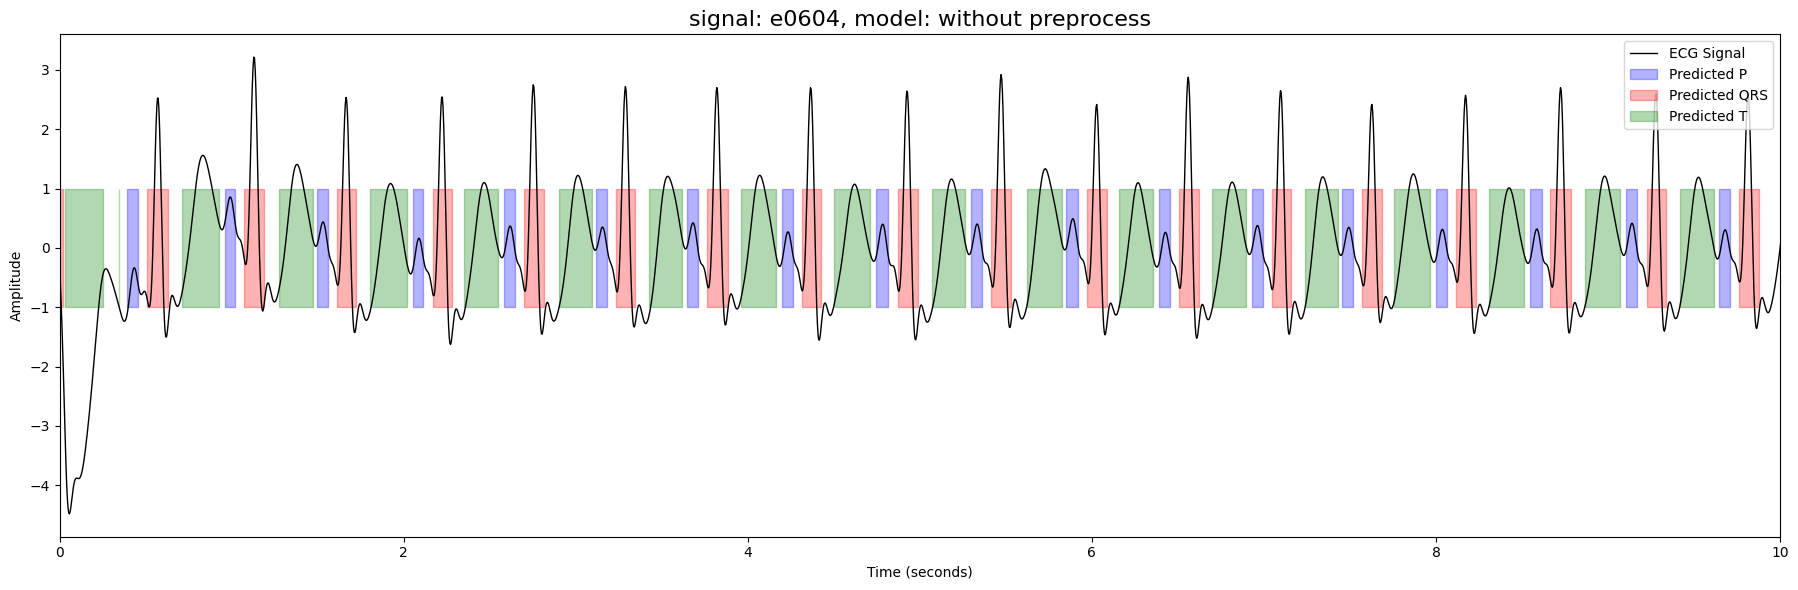

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


Processing QRS: 100%|██████████| 25/25 [00:00<00:00, 7904.83it/s]


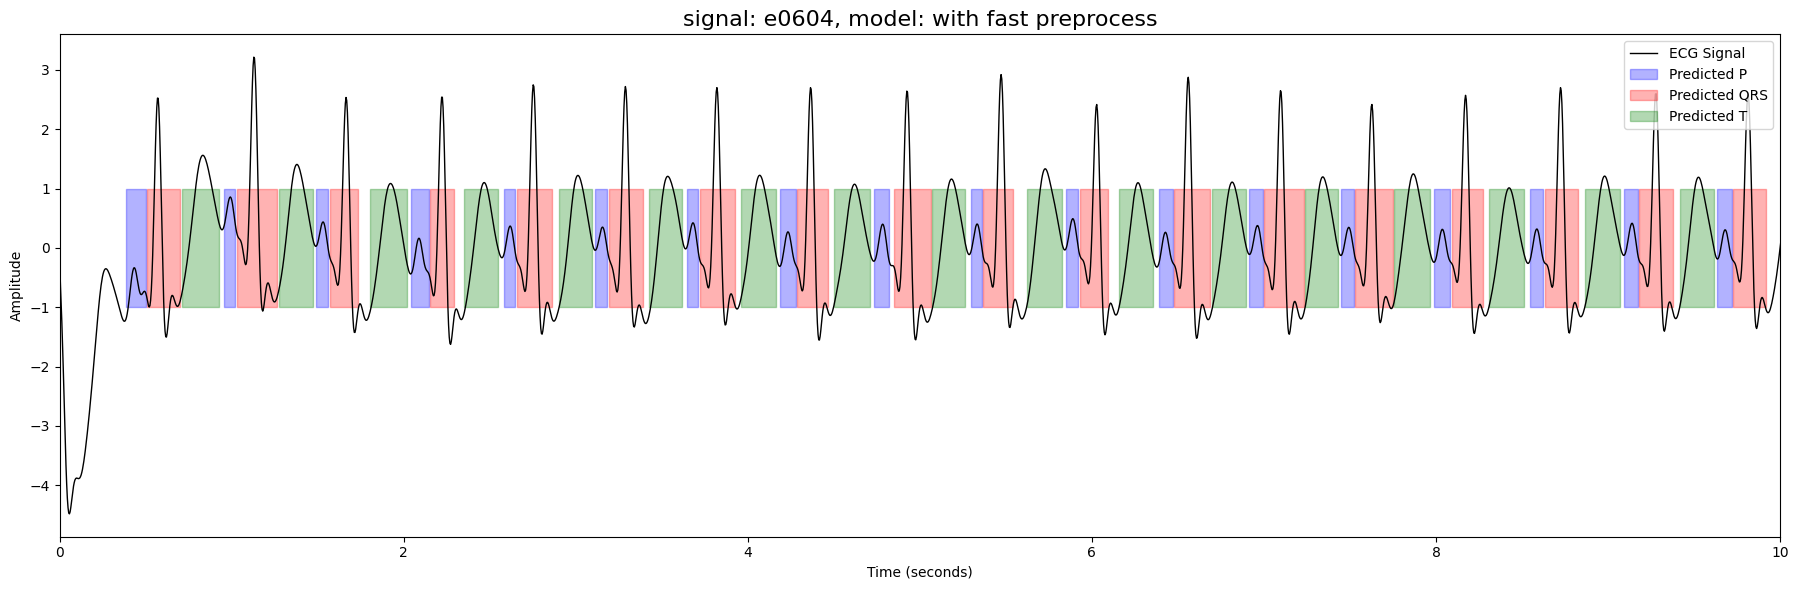

In [24]:
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '213'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = signal[int(10*fs):int(25*fs)]
mask,segments,_ = predict_full_ecg(signal, model_deep, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="without preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")

# Post-process mask
mask = remove_uncomplete_first_last_wave(mask)
mask = merge_close_waves(mask)
mask = remove_irrelevant_waves(mask)
mask = check_repeated_waves(mask)
mask = fix_P(signal, mask)
mask = fast_fix_QRS(signal, mask, fs=250)
mask = merge_close_waves(mask)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))

In [25]:

X = signal.reshape(1, 1, -1)  # shape: (1, 1, L)
all_predicted_masks = mask.reshape(1, -1)  # shape: (1, L)
print(X.shape)
print(all_predicted_masks.shape)


(1, 1, 3600)
(1, 3600)


In [26]:
import pandas as pd
features_per_beat = extract_features_per_qrs(signal, all_predicted_masks.flatten(), fs)

extract features: 100%|██████████| 25/25 [00:03<00:00,  8.01it/s]


beat:  10
beat_features:  {'start': 1463, 'end': 1590, 'qrs_start': 1482, 'qrs_end': 1525, 'p_start': 1463, 'p_end': 1481, 't_start': 1540, 't_end': 1590, 'Duree_P_ms': 52.77777777777778, 'Duree_QRS_ms': 122.22222222222221, 'Duree_T_ms': 141.66666666666666, 'Intervalle_PR_ms': 52.77777777777778, 'Intervalle_QT_ms': 300.0, 'Intervalle_ST_ms': 41.666666666666664, 'P_index': 1472, 'Amplitude_P': 0.4917166269634759, 'R_index': 1507, 'Amplitude_R': 2.4151427135674357, 'Intervalle_RR_ms': 386.11111111111114, 'Q_index': 1495, 'Amplitude_Q': -0.6064940439044006, 'S_index': 1519, 'Amplitude_S': -1.4650742731400286, 'T_index': 1567, 'Amplitude_T': 1.0986385674401018, 'T/R_ratio': 0.4548959203397508, 'P/R_ratio': 0.20359733783067233, 'QRS_area': 0.10939269977693478, 'Slope_QR': 90.64910272415509, 'Slope_RS': -116.40650960122392, 'P_symmetry': 0.915783649874278, 'T_inversion': 0, 'QRS_axis_estimate': 0.3469272094379401, 'Heart_rate_bpm': 155.3956834532374, 'Premature_beat': 0, 'Local_RR_variabilit

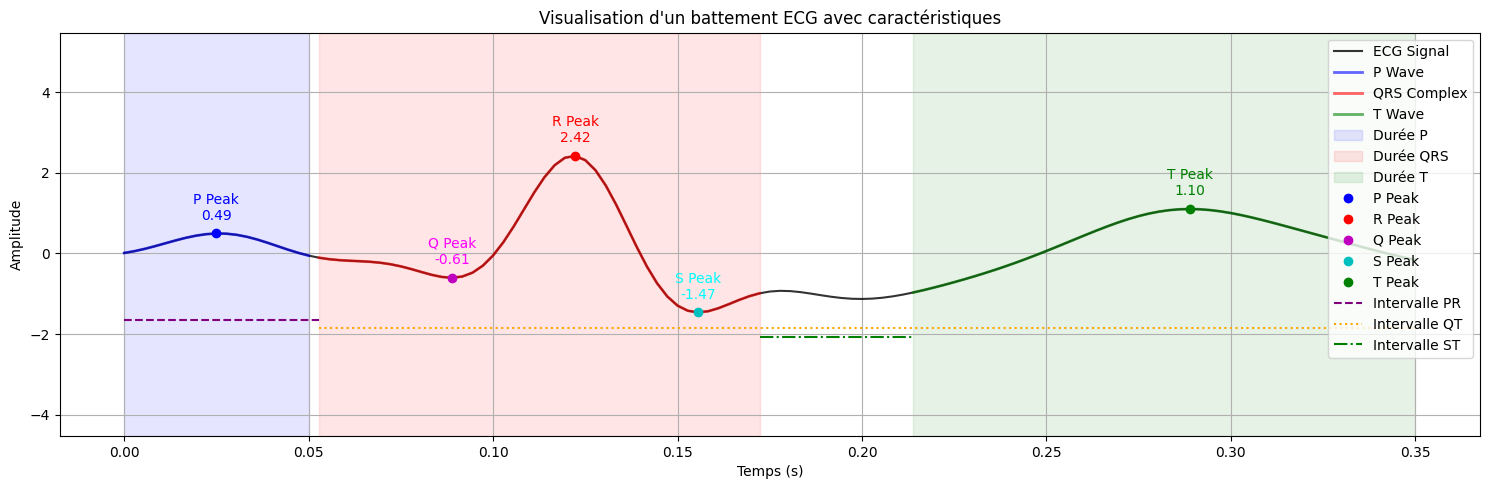

beat:  11
beat_features:  {'start': 1597, 'end': 1725, 'qrs_start': 1620, 'qrs_end': 1673, 'p_start': 1597, 'p_end': 1619, 't_start': 1674, 't_end': 1725, 'Duree_P_ms': 63.888888888888886, 'Duree_QRS_ms': 150.0, 'Duree_T_ms': 144.44444444444443, 'Intervalle_PR_ms': 63.888888888888886, 'Intervalle_QT_ms': 291.6666666666667, 'Intervalle_ST_ms': 2.7777777777777777, 'P_index': 1607, 'Amplitude_P': 0.2628071592305854, 'R_index': 1639, 'Amplitude_R': 2.7997842629215697, 'Intervalle_RR_ms': 366.66666666666663, 'Q_index': 1628, 'Amplitude_Q': -0.6826882838661736, 'S_index': 1652, 'Amplitude_S': -1.5240986640924585, 'T_index': 1704, 'Amplitude_T': 1.1080253590322642, 'T/R_ratio': 0.3855301427994325, 'P/R_ratio': 0.09598185507581024, 'QRS_area': 0.16808775532811696, 'Slope_QR': 113.97182880396252, 'Slope_RS': -119.7382964403885, 'P_symmetry': -2.035885882730444, 'T_inversion': 0, 'QRS_axis_estimate': 0.3911606185244623, 'Heart_rate_bpm': 163.63636363636365, 'Premature_beat': 0, 'Local_RR_variabi

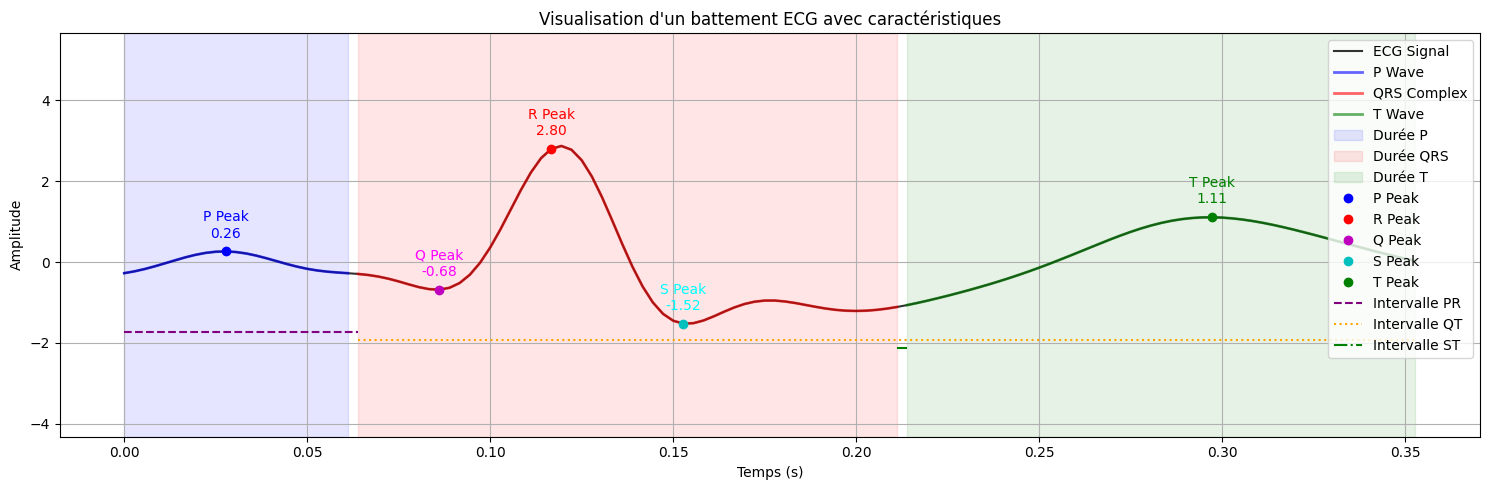

beat:  12
beat_features:  {'start': 1729, 'end': 1858, 'qrs_start': 1750, 'qrs_end': 1809, 'p_start': 1729, 'p_end': 1749, 't_start': 1810, 't_end': 1858, 'Duree_P_ms': 58.333333333333336, 'Duree_QRS_ms': 166.66666666666666, 'Duree_T_ms': 136.1111111111111, 'Intervalle_PR_ms': 58.333333333333336, 'Intervalle_QT_ms': 300.0, 'Intervalle_ST_ms': 2.7777777777777777, 'P_index': 1741, 'Amplitude_P': 0.3753273166294628, 'R_index': 1775, 'Amplitude_R': 2.6242932654535664, 'Intervalle_RR_ms': 377.77777777777777, 'Q_index': 1762, 'Amplitude_Q': -0.7057184404685092, 'S_index': 1787, 'Amplitude_S': -1.4553854198141536, 'T_index': 1836, 'Amplitude_T': 1.195021199105301, 'T/R_ratio': 0.4513030451527377, 'P/R_ratio': 0.14174339421819462, 'QRS_area': 0.16782423804697705, 'Slope_QR': 92.21570877938056, 'Slope_RS': -122.3903605580316, 'P_symmetry': -1.2797647316626204, 'T_inversion': 0, 'QRS_axis_estimate': 0.3917388348580741, 'Heart_rate_bpm': 158.8235294117647, 'Premature_beat': 0, 'Local_RR_variabili

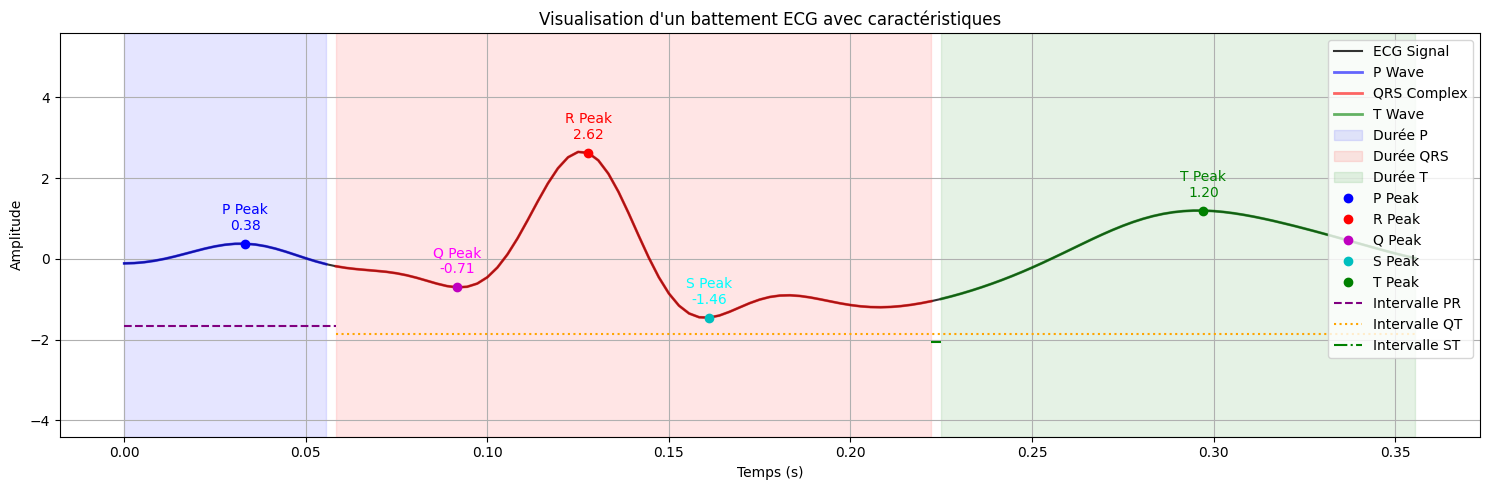

beat:  13
beat_features:  {'start': 1862, 'end': 1993, 'qrs_start': 1883, 'qrs_end': 1938, 'p_start': 1862, 'p_end': 1882, 't_start': 1939, 't_end': 1993, 'Duree_P_ms': 58.333333333333336, 'Duree_QRS_ms': 155.55555555555557, 'Duree_T_ms': 152.7777777777778, 'Intervalle_PR_ms': 58.333333333333336, 'Intervalle_QT_ms': 305.5555555555556, 'Intervalle_ST_ms': 2.7777777777777777, 'P_index': 1873, 'Amplitude_P': 0.34520930199974464, 'R_index': 1906, 'Amplitude_R': 2.37976241534998, 'Intervalle_RR_ms': 363.88888888888886, 'Q_index': 1895, 'Amplitude_Q': -0.6396403138817234, 'S_index': 1919, 'Amplitude_S': -1.26011956180445, 'T_index': 1967, 'Amplitude_T': 1.2470509193352426, 'T/R_ratio': 0.5162879914968259, 'P/R_ratio': 0.14291911774579014, 'QRS_area': 0.1406487171886956, 'Slope_QR': 98.81681659303757, 'Slope_RS': -100.79673167504576, 'P_symmetry': -1.327260318824568, 'T_inversion': 0, 'QRS_axis_estimate': 0.4110932568382628, 'Heart_rate_bpm': 164.88549618320613, 'Premature_beat': 0, 'Local_RR

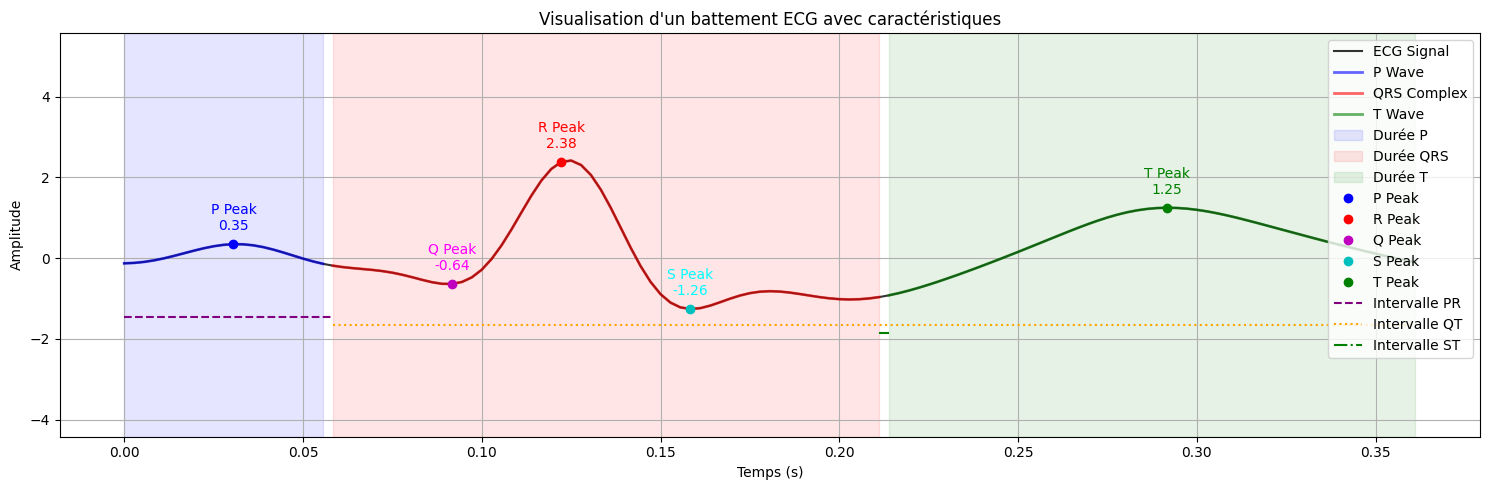

beat:  14
beat_features:  {'start': 1997, 'end': 2129, 'qrs_start': 2023, 'qrs_end': 2069, 'p_start': 1997, 'p_end': 2022, 't_start': 2077, 't_end': 2129, 'Duree_P_ms': 72.22222222222221, 'Duree_QRS_ms': 130.55555555555557, 'Duree_T_ms': 147.22222222222223, 'Intervalle_PR_ms': 72.22222222222221, 'Intervalle_QT_ms': 294.44444444444446, 'Intervalle_ST_ms': 22.22222222222222, 'P_index': 2009, 'Amplitude_P': 0.31231566726957927, 'R_index': 2043, 'Amplitude_R': 2.5699334520446704, 'Intervalle_RR_ms': 380.55555555555554, 'Q_index': 2031, 'Amplitude_Q': -0.581590624502711, 'S_index': 2056, 'Amplitude_S': -1.4416906519951238, 'T_index': 2106, 'Amplitude_T': 1.0111659654464447, 'T/R_ratio': 0.3934599803126998, 'P/R_ratio': 0.12152675277295492, 'QRS_area': 0.1334765258965263, 'Slope_QR': 94.54572229642145, 'Slope_RS': -111.09112903494815, 'P_symmetry': -0.12830237694310154, 'T_inversion': 0, 'QRS_axis_estimate': 0.37225193102236737, 'Heart_rate_bpm': 157.66423357664235, 'Premature_beat': 0, 'Loc

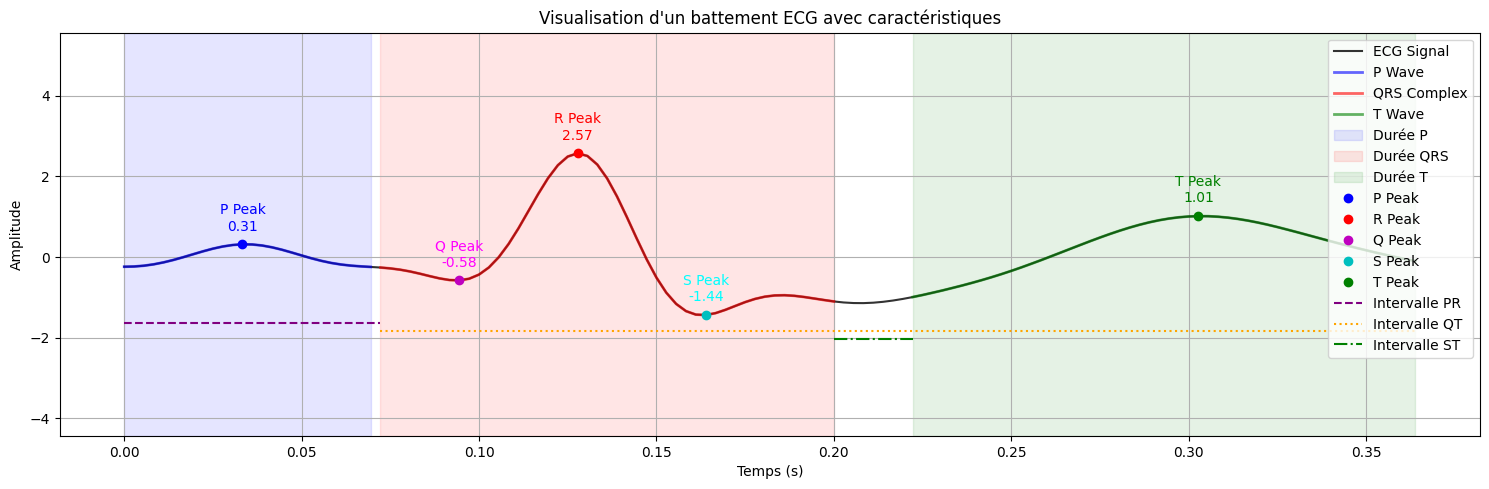

beat:  15
beat_features:  {'start': 2136, 'end': 2269, 'qrs_start': 2158, 'qrs_end': 2208, 'p_start': 2136, 'p_end': 2157, 't_start': 2217, 't_end': 2269, 'Duree_P_ms': 61.11111111111111, 'Duree_QRS_ms': 141.66666666666666, 'Duree_T_ms': 147.22222222222223, 'Intervalle_PR_ms': 61.11111111111111, 'Intervalle_QT_ms': 308.33333333333337, 'Intervalle_ST_ms': 25.0, 'P_index': 2147, 'Amplitude_P': 0.31691594443516063, 'R_index': 2182, 'Amplitude_R': 2.649263446152255, 'Intervalle_RR_ms': 386.11111111111114, 'Q_index': 2169, 'Amplitude_Q': -0.6645690634554998, 'S_index': 2194, 'Amplitude_S': -1.4349401781059292, 'T_index': 2245, 'Amplitude_T': 1.2098145275982457, 'T/R_ratio': 0.44828784551877615, 'P/R_ratio': 0.11743086456684101, 'QRS_area': 0.1421887075742935, 'Slope_QR': 91.76766949683014, 'Slope_RS': -122.52610872774552, 'P_symmetry': 0.9809539405985842, 'T_inversion': 0, 'QRS_axis_estimate': 0.39565842785117555, 'Heart_rate_bpm': 155.3956834532374, 'Premature_beat': 0, 'Local_RR_variabili

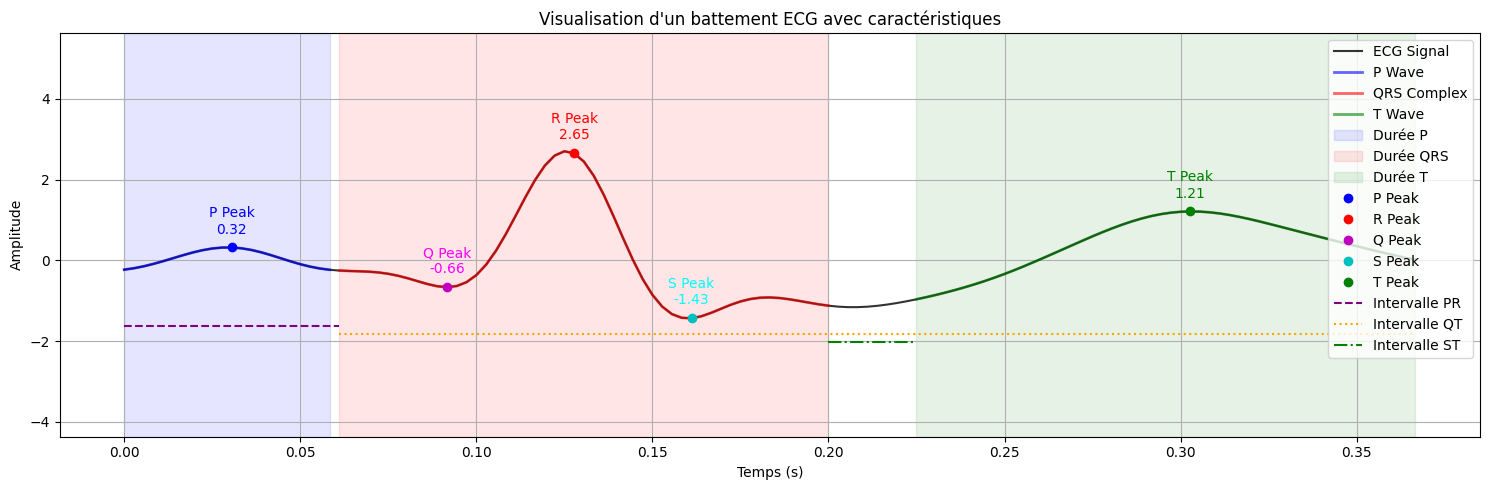

beat:  16
beat_features:  {'start': 2273, 'end': 2405, 'qrs_start': 2295, 'qrs_end': 2346, 'p_start': 2273, 'p_end': 2294, 't_start': 2354, 't_end': 2405, 'Duree_P_ms': 61.11111111111111, 'Duree_QRS_ms': 144.44444444444443, 'Duree_T_ms': 144.44444444444443, 'Intervalle_PR_ms': 61.11111111111111, 'Intervalle_QT_ms': 305.5555555555556, 'Intervalle_ST_ms': 22.22222222222222, 'P_index': 2285, 'Amplitude_P': 0.41517973666157865, 'R_index': 2319, 'Amplitude_R': 2.5912630845880025, 'Intervalle_RR_ms': 380.55555555555554, 'Q_index': 2307, 'Amplitude_Q': -0.6510715691993639, 'S_index': 2332, 'Amplitude_S': -1.404930059074835, 'T_index': 2382, 'Amplitude_T': 1.1891794122322787, 'T/R_ratio': 0.45802274275255084, 'P/R_ratio': 0.15991006888023246, 'QRS_area': 0.13867939455734946, 'Slope_QR': 97.270039613621, 'Slope_RS': -110.66381013220166, 'P_symmetry': -0.3442677379051369, 'T_inversion': 0, 'QRS_axis_estimate': 0.3953732599423272, 'Heart_rate_bpm': 157.66423357664235, 'Premature_beat': 0, 'Local_

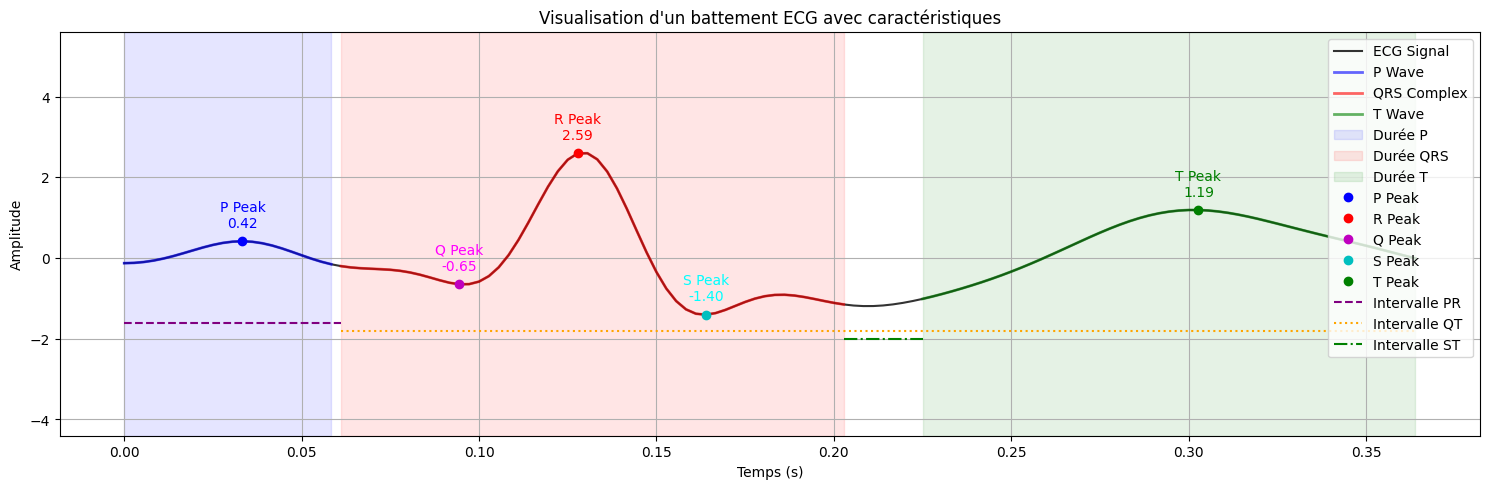

beat:  17
beat_features:  {'start': 2409, 'end': 2543, 'qrs_start': 2432, 'qrs_end': 2480, 'p_start': 2409, 'p_end': 2431, 't_start': 2488, 't_end': 2543, 'Duree_P_ms': 63.888888888888886, 'Duree_QRS_ms': 136.1111111111111, 'Duree_T_ms': 155.55555555555557, 'Intervalle_PR_ms': 63.888888888888886, 'Intervalle_QT_ms': 308.33333333333337, 'Intervalle_ST_ms': 22.22222222222222, 'P_index': 2420, 'Amplitude_P': 0.30421202054988156, 'R_index': 2453, 'Amplitude_R': 2.563117261513427, 'Intervalle_RR_ms': 372.22222222222223, 'Q_index': 2441, 'Amplitude_Q': -0.5746768371401887, 'S_index': 2466, 'Amplitude_S': -1.3590968550479516, 'T_index': 2517, 'Amplitude_T': 1.2372469764553413, 'T/R_ratio': 0.48050858946922875, 'P/R_ratio': 0.11814657192600049, 'QRS_area': 0.13117049610778672, 'Slope_QR': 94.13382295960847, 'Slope_RS': -108.61516015093049, 'P_symmetry': -1.1098300186255536, 'T_inversion': 0, 'QRS_axis_estimate': 0.39553924397528584, 'Heart_rate_bpm': 161.19402985074626, 'Premature_beat': 0, 'L

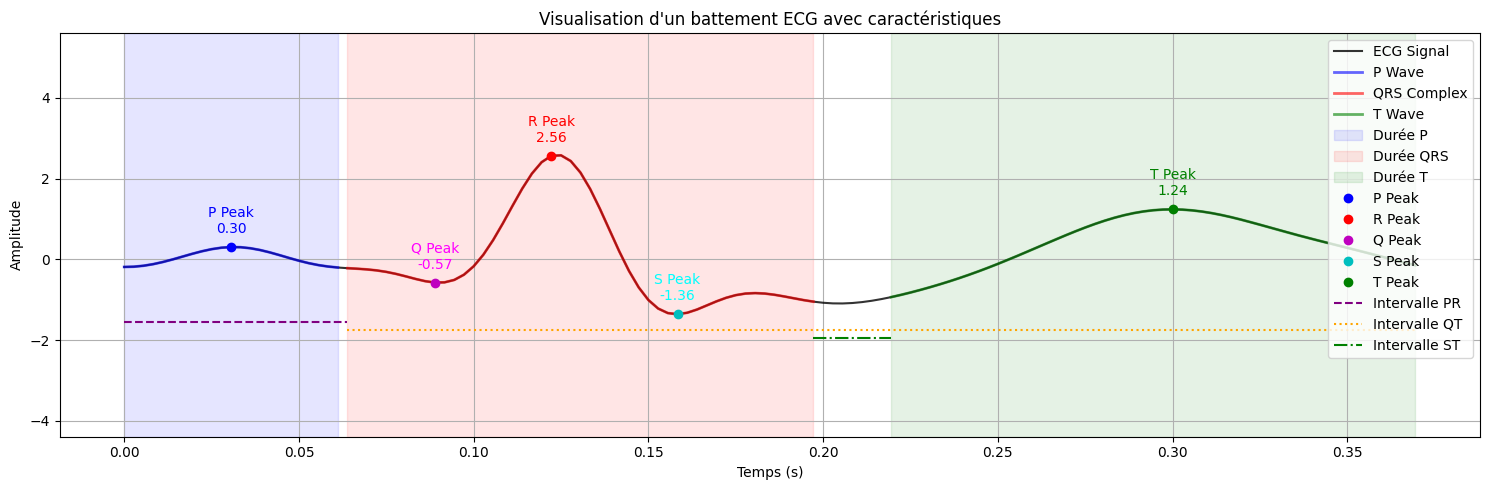

beat:  18
beat_features:  {'start': 2549, 'end': 2673, 'qrs_start': 2573, 'qrs_end': 2624, 'p_start': 2549, 'p_end': 2572, 't_start': 2625, 't_end': 2673, 'Duree_P_ms': 66.66666666666667, 'Duree_QRS_ms': 144.44444444444443, 'Duree_T_ms': 136.1111111111111, 'Intervalle_PR_ms': 66.66666666666667, 'Intervalle_QT_ms': 277.77777777777777, 'Intervalle_ST_ms': 2.7777777777777777, 'P_index': 2559, 'Amplitude_P': 0.34242467198504317, 'R_index': 2591, 'Amplitude_R': 2.42357356895457, 'Intervalle_RR_ms': 383.33333333333337, 'Q_index': 2579, 'Amplitude_Q': -0.6446477842143198, 'S_index': 2604, 'Amplitude_S': -1.5197642967081544, 'T_index': 2651, 'Amplitude_T': 1.0978344581411892, 'T/R_ratio': 0.45298169290348794, 'P/R_ratio': 0.141289159269364, 'QRS_area': 0.1525609372259436, 'Slope_QR': 92.04664059506669, 'Slope_RS': -109.20012551066007, 'P_symmetry': -0.22133675725224577, 'T_inversion': 0, 'QRS_axis_estimate': 0.3375025200873749, 'Heart_rate_bpm': 156.52173913043475, 'Premature_beat': 0, 'Local_

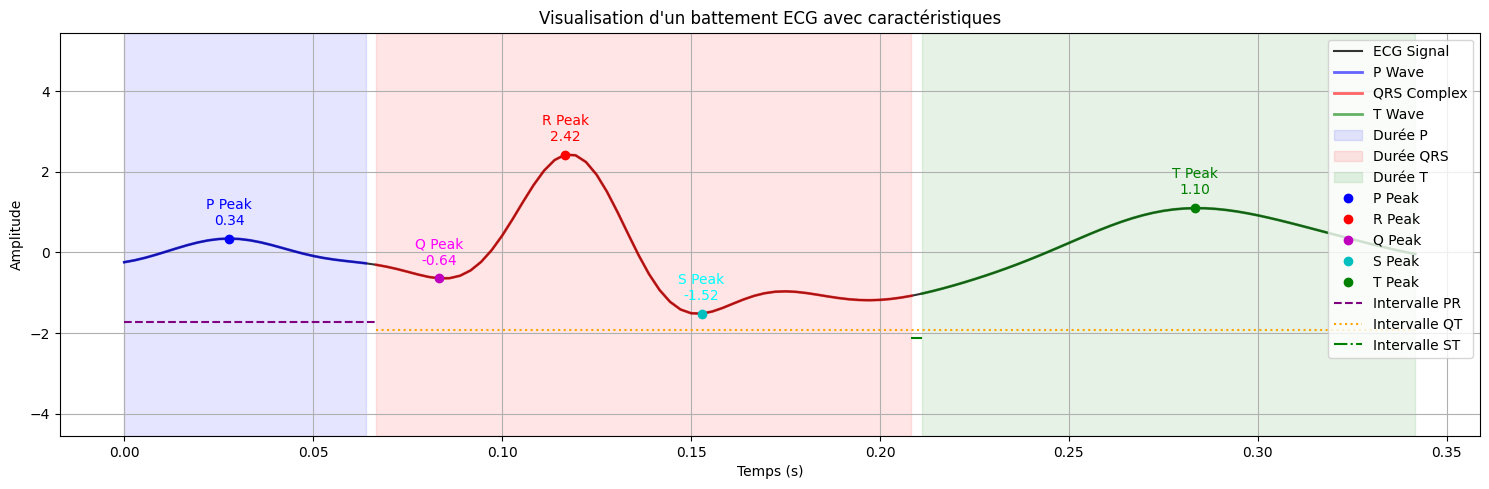

beat:  19
beat_features:  {'start': 2679, 'end': 2809, 'qrs_start': 2699, 'qrs_end': 2757, 'p_start': 2679, 'p_end': 2698, 't_start': 2758, 't_end': 2809, 'Duree_P_ms': 55.55555555555555, 'Duree_QRS_ms': 163.88888888888889, 'Duree_T_ms': 144.44444444444443, 'Intervalle_PR_ms': 55.55555555555555, 'Intervalle_QT_ms': 305.5555555555556, 'Intervalle_ST_ms': 2.7777777777777777, 'P_index': 2689, 'Amplitude_P': 0.37286632361973715, 'R_index': 2723, 'Amplitude_R': 2.722804496673448, 'Intervalle_RR_ms': 366.66666666666663, 'Q_index': 2710, 'Amplitude_Q': -0.6995887845334051, 'S_index': 2735, 'Amplitude_S': -1.4689252958629733, 'T_index': 2786, 'Amplitude_T': 1.201413588425306, 'T/R_ratio': 0.4412412238532432, 'P/R_ratio': 0.13694201110483029, 'QRS_area': 0.1720207134177163, 'Slope_QR': 94.77396778726671, 'Slope_RS': -125.75189377609263, 'P_symmetry': 0.8990882291130092, 'T_inversion': 0, 'QRS_axis_estimate': 0.3993744335376501, 'Heart_rate_bpm': 163.63636363636365, 'Premature_beat': 0, 'Local_R

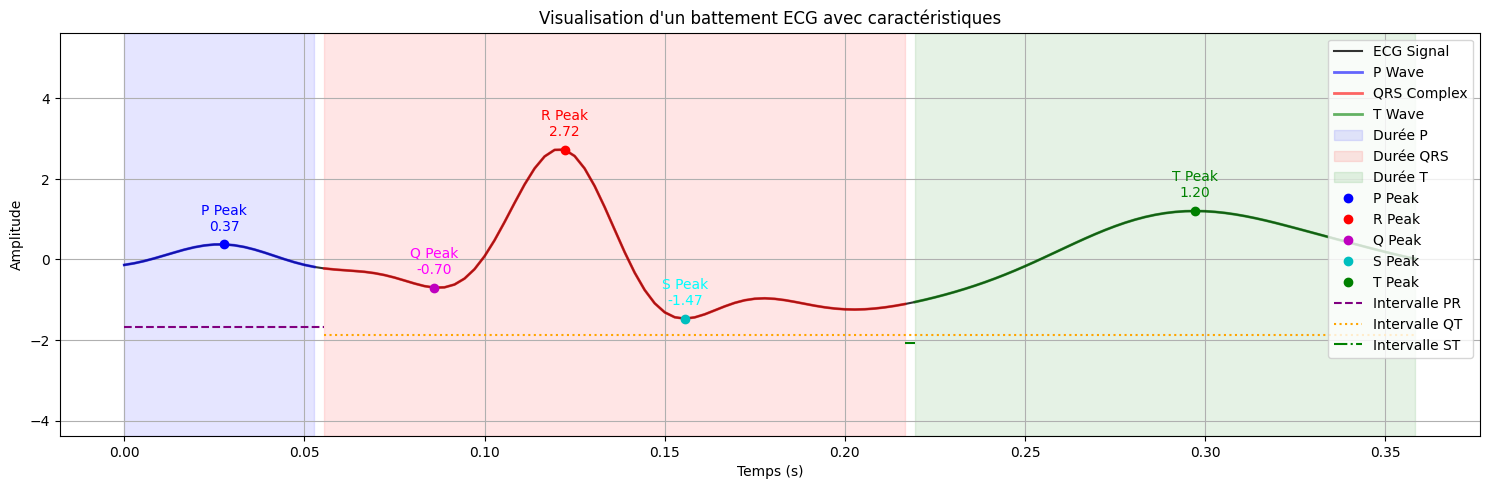

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Convert list of dicts to dict of lists (easier for plotting)
feature_dict = {}
for f in features_per_beat[-10:]:
    for key, val in f.items():
        feature_dict.setdefault(key, []).append(val)

beats = np.arange(1, len(features_per_beat) + 1)

for i in beats[10:20]:

  beat_idx = i - 1
  print("beat: ", beat_idx)
  feat = features_per_beat[beat_idx]

  start, end = feat['start'], feat['end']
  #start, end = int(start*250), int(end*250)

  plot_beat_with_features(
      signal[start:end],
      all_predicted_masks.flatten()[start:end],
      beat_features=feat,
      fs=fs,
      window_start=start
  )
